# Customer churn

Customers began to leave Beta-Bank. Every month. A little, but noticeable. Banking marketers figured it was cheaper to keep current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. You are provided with historical data on customer behavior and termination of agreements with the bank.

Build a model with an extremely large *F1*-measure. To pass the project successfully, you need to bring the metric to 0.59. Check the *F1*-measure on the test set yourself.

Additionally measure *AUC-ROC*, compare its value with *F1*-measure.

## Data preparation

Let's look at the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# sklean
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import roc_curve, f1_score, accuracy_score, roc_auc_score
from sklearn.utils import shuffle

# learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
# constants
RANDOM_STATE=654321

### First look

In [3]:
data = pd.read_csv('datasets/Churn.csv')

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


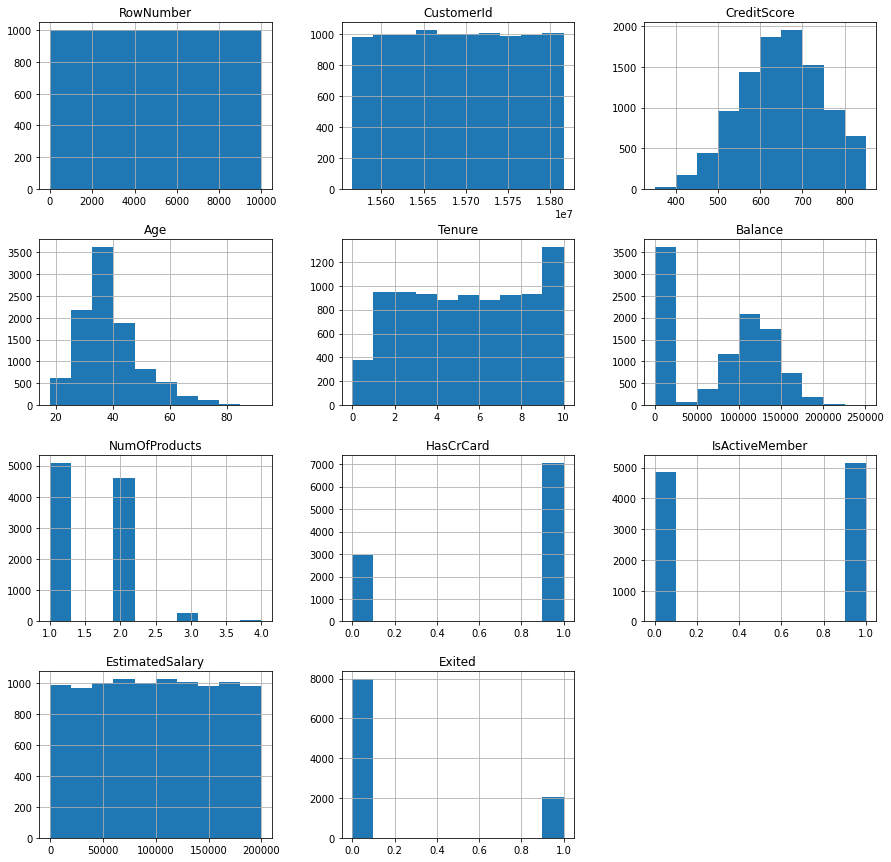

In [7]:
data.hist(figsize=(15,15))
plt.show()

#### Conclusion

What are our conclusions after the first look at the data?
<ol>
    <li>Empty values:
        <ul>
            <li>Tenure</li>
        </ul>
    </li>
    <li>Class balance:
        <ul>
            <li>Exited - large variation between 0 и 1</li>
            <li>HasCrCard - large variation between 0 и 1</li>
            <li>Balance - a lot of clients with 0 balance</li>
        </ul>
    </li>
    <li>Convert columns to lower snake case</li>
</ol>

### Data preprocessing

#### Removing extra columns

To train our prediction model, we will not need all the columns from our data. Let's check columns CustomerId, RowNumber, Surname

In [8]:
len(data['CustomerId'].unique())

10000

In [9]:
len(data['RowNumber'].unique())

10000

In [10]:
len(data['Surname'].unique())

2932

We see that columns CustomerId и RowNumber are unique for every customer (line), so they are not relevant for our model. The Surname of the client should also not affect the prediction of the model. We'll drop these columns.

In [11]:
data = data.drop(['CustomerId', 'RowNumber', 'Surname'], axis=1)

In [12]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Excellent! Now only the columns we need are left in our table.

#### Column naming

Let's convert the column names to snake case

In [13]:
dict_columns = {'CreditScore':'credit_score'
                ,'Geography':'geography'
                ,'Gender':'gender'
                ,'Age':'age'
                ,'Tenure':'tenure'
                ,'Balance':'balance'
                ,'NumOfProducts':'num_of_products'
                ,'HasCrCard':'has_cr_card'
                ,'IsActiveMember':'is_active_member'
                ,'EstimatedSalary':'estimated_salary'
                ,'Exited':'exited'
               }

In [14]:
data = data.rename(mapper=dict_columns, axis=1) 

In [15]:
data.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

#### Duplicates

Let's check for duplicates

In [16]:
data['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [17]:
data['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [18]:
data.duplicated().sum()

0

There are no duplicates

#### Ordinal encoding

Let's replace two categorical columns: geography and gender with numerical values

In [19]:
encoder = OrdinalEncoder()
ordinal_data = data
ordinal_data[['geography', 'gender']] = encoder.fit_transform(ordinal_data[['geography', 'gender']])

In [20]:
ordinal_data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,0.0,0.0,42,2.0,0.00,1,1,1,101348.88,1
1,608,2.0,0.0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,0.0,0.0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,0.0,0.0,39,1.0,0.00,2,0,0,93826.63,0
4,850,2.0,0.0,43,2.0,125510.82,1,1,1,79084.10,0


What categories do we have now?

In [21]:
encoder.categories_

[array(['France', 'Germany', 'Spain'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

#### Empty values

Look at the gaps in "tenure" column 

In [22]:
def percentage(part, whole):
    return 100 * float(part)/float(whole)

In [23]:
percentage(ordinal_data['tenure'].isna().sum(), len(ordinal_data['tenure']))

9.09

9% is quite a lot. We can't delete that much data. So let's try to replace them with similar values

In [24]:
ordinal_data['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

Let's replace empty values with -1 and look at the data distribution

In [25]:
ordinal_data.loc[ordinal_data['tenure'].isna(), 'tenure'] = -1

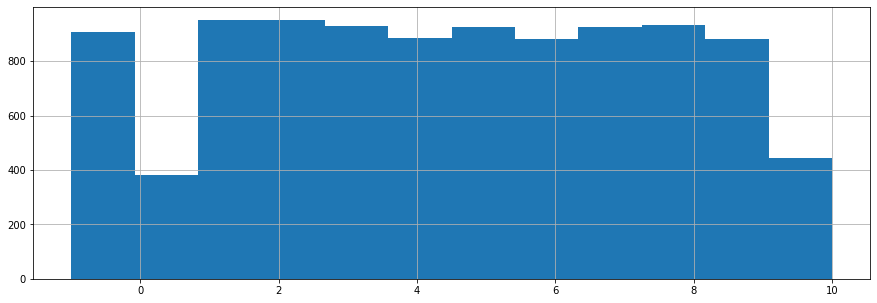

In [26]:
ordinal_data['tenure'].hist(figsize=(15,5), bins=len(ordinal_data['tenure'].unique()))
plt.show()

In general, the distribution is even

Let's replace the missing values with those that are in similar records

In [27]:
ordinal_data.loc[ordinal_data['tenure'] == -1, 'tenure'] = np.nan

In [28]:
imputer = KNNImputer(n_neighbors=5, weights='distance')
ord_imp_data = pd.DataFrame(imputer.fit_transform(ordinal_data), columns=ordinal_data.columns)

In [29]:
len(ord_imp_data['tenure'].unique())

920

In [30]:
ord_imp_data['tenure'].sort_values().unique()[:15]

array([0.        , 0.77303732, 0.92647587, 1.        , 1.37327642,
       1.58446455, 1.65733016, 1.70105147, 1.71913281, 1.78999893,
       1.85582678, 1.88332841, 1.90106895, 1.91766267, 1.97207031])

Too many new values. Let's round them up.

In [31]:
ord_imp_data['tenure'] = round(ord_imp_data['tenure'])

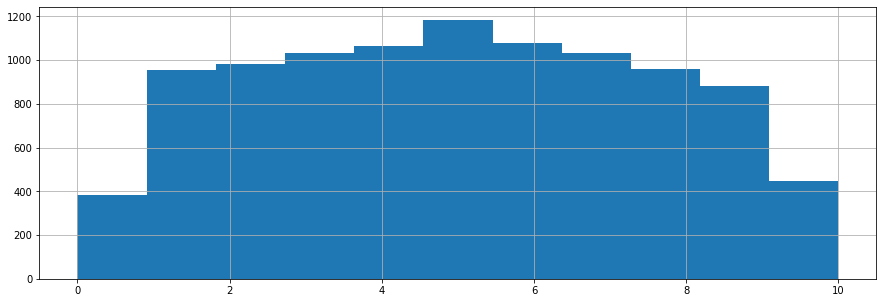

In [32]:
ord_imp_data['tenure'].hist(figsize=(15,5), bins=len(ord_imp_data['tenure'].unique()))
plt.show()

In general, we see that those -1 values have moved inside the graph. And the graph is still significantly lower in 0 and 10 and is generally normally distributed between these values.

In [33]:
ord_imp_data['tenure'].value_counts()

5.0     1184
6.0     1079
4.0     1065
3.0     1033
7.0     1032
2.0      981
8.0      959
1.0      955
9.0      884
10.0     446
0.0      382
Name: tenure, dtype: int64

In [34]:
len(ord_imp_data['tenure'])

10000

In [35]:
ord_imp_data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619.0,0.0,0.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,1.0
1,608.0,2.0,0.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0
2,502.0,0.0,0.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0
3,699.0,0.0,0.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,0.0
4,850.0,2.0,0.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0


Data preprocessing is finished!

## Problem investigation

Let's look at the data balance

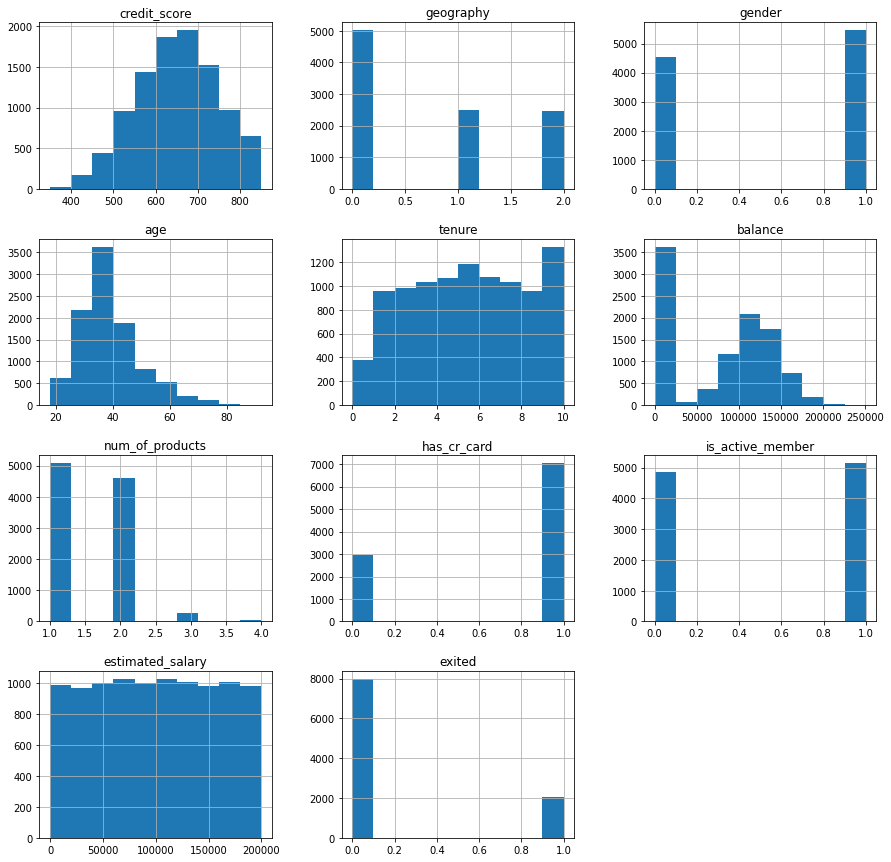

In [36]:
ord_imp_data.hist(figsize=(15,15))
plt.show()

We have noticed that we have significantly less customers with exited = 1 than exited = 0. This can affect the training of our model. Let's see how the model learns from such a dataset.

In [37]:
ord_imp_data['exited'].value_counts(normalize=True)

0.0    0.7963
1.0    0.2037
Name: exited, dtype: float64

Here we see that the values with exited=1 take about 1/5 (20%) of the entire sample, and exited=0 is 4/5 (80%)

### Data separation

Let's divide the data into 3 samples - training, validation, and test

In [38]:
features = ord_imp_data.drop(['exited'], axis=1)
target = ord_imp_data['exited']

In [39]:
features_train, features_test, target_train, target_test = (
    train_test_split(features, target, test_size=0.4, random_state=RANDOM_STATE, stratify=target)
)

In [40]:
features_valid, features_test, target_valid, target_test = (
    train_test_split(features_test, target_test, test_size=0.5, random_state=RANDOM_STATE, stratify=target_test)
)

In [41]:
f'''Training: \
{features_train.shape[0]}, \
{target_train.shape[0]}, \
{round(features_train.shape[0]/ord_imp_data.shape[0]*100, 2)}%'''

'Training: 6000, 6000, 60.0%'

In [42]:
f'''Validation: \
{features_valid.shape[0]}, \
{target_valid.shape[0]}, \
{round(features_valid.shape[0]/ord_imp_data.shape[0]*100, 2)}%'''

'Validation: 2000, 2000, 20.0%'

In [43]:
f'''Test: \
{features_test.shape[0]}, \
{target_test.shape[0]}, \
{round(features_test.shape[0]/ord_imp_data.shape[0]*100, 2)}%'''

'Test: 2000, 2000, 20.0%'

### Scaling

Since we assume that all features are equal, we need to scale them

In [44]:
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train)

features_train[features_train.columns] = scaler.transform(features_train[features_train.columns])
features_valid[features_valid.columns] = scaler.transform(features_valid[features_valid.columns])
features_test[features_test.columns] = scaler.transform(features_test[features_test.columns])

Let's look at the results

In [45]:
features_train.head(2)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
8555,-1.345988,0.297383,0.91894,-1.342356,-1.435019,0.547136,-0.919628,0.655433,0.968819,1.197259
4080,1.635263,0.297383,-1.08821,-0.192190,0.710804,0.371407,-0.919628,0.655433,-1.032184,-1.125695


In [46]:
features_valid.head(2)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
6810,-1.095813,0.297383,-1.08821,0.287046,1.426078,0.146481,0.802522,0.655433,-1.032184,-0.738841
4207,0.050822,-0.909039,0.91894,-0.192190,0.710804,0.560861,-0.919628,0.655433,-1.032184,0.927195


In [47]:
features_test.head(2)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
467,1.718655,0.297383,-1.08821,-0.096342,-0.004470,0.857793,2.524671,0.655433,-1.032184,-0.48617
2,-1.554467,-0.909039,-1.08821,0.287046,1.068441,1.317583,2.524671,0.655433,-1.032184,0.24486


Scaling is done.

### Model training

#### Decision tree

Let's find the best hyperparameters for the decision tree:
<li>max_depth - from 1 to 10</li>
<li>splitters - best and random</li>
<li>criterion - gini and entropy</li>

In [48]:
def find_best_tree_model(_features_train, _features_valid, _target_train, _target_valid): 
    best_tree_model = None
    best_tree_f1_score = 0
    best_tree_auc_roc = 0
    best_tree_depth = 0
    best_tree_splitter = None
    best_tree_criterion = None

    # hyperparameters
    num_tree_depths = 10
    splitters = ['best', 'random']
    tree_criterions = ['gini', 'entropy']

    for spltr in splitters:
        for crit in tree_criterions:
            for depth in range(1,num_tree_depths+1):
                model_tree = (
                    DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, 
                                           splitter=spltr, criterion=crit)
                )
                model_tree.fit(_features_train, _target_train)
                predictions_valid = model_tree.predict(_features_valid)
                f1 = f1_score(_target_valid, predictions_valid)
                
                if f1 > best_tree_f1_score:
                    best_tree_model = model_tree
                    best_tree_f1_score = f1
                    best_tree_depth = depth
                    best_tree_splitter = spltr
                    best_tree_criterion = crit
                    probabilities_valid = model_tree.predict_proba(_features_valid)
                    best_tree_auc_roc = roc_auc_score(_target_valid, probabilities_valid[:, 1])

    tree_final_result = {'f1_score':round(best_tree_f1_score, 5),
                         'auc_roc': best_tree_auc_roc,
                         'depth': best_tree_depth,
                         'splitter': best_tree_splitter,
                         'citerion': best_tree_criterion
                        }
    return tree_final_result

In [49]:
tree_asis_result = find_best_tree_model(features_train, features_valid, target_train, target_valid)

In [50]:
tree_asis_result

{'f1_score': 0.53659,
 'auc_roc': 0.7928436607054882,
 'depth': 9,
 'splitter': 'random',
 'citerion': 'gini'}

In [51]:
model_results = (
    pd.DataFrame([['Tree', 'Not fixed', tree_asis_result['f1_score'], tree_asis_result['auc_roc']]],
                 columns=['model', 'disbalance', 'f1_score', 'auc_roc_score'])
)

In [52]:
model_results

,model,disbalance,f1_score,auc_roc_score
0,Tree,Not fixed,0.53659,0.792844


#### Random forest

Let's find the best hyperparameters for the random forest:
<li>n_estimators - from 10 to 150, with step=10</li>
<li>max_depth - from 4 to 10</li>
<li>criterion - gini and entropy</li>

In [53]:
def find_best_forest_model(_features_train, _features_valid, _target_train, _target_valid): 
    best_forest_model = None
    best_forest_f1_score = 0
    best_forest_auc_roc = 0
    best_forest_size = 0
    best_forest_tree_depth = 0
    best_forest_criterion = None

    # hyperparameters
    num_forest_depths = range(10,151,10)
    num_forest_tree_depths = range(4,11)
    forest_criterions = ['gini', 'entropy']

    for crit in forest_criterions:
        for size in num_forest_depths:
            for depth in num_forest_tree_depths:
                model_forest = (
                    RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=size, 
                                           max_depth=depth, criterion=crit)
                )
                model_forest.fit(_features_train, _target_train)
                predictions_valid = model_forest.predict(_features_valid)
                f1 = f1_score(_target_valid, predictions_valid)
                
                if f1 > best_forest_f1_score:
                    best_forest_model = model_forest
                    best_forest_f1_score = f1
                    best_forest_size = size
                    best_forest_tree_depth = depth
                    best_forest_criterion = crit
                    probabilities_valid = model_forest.predict_proba(_features_valid)
                    best_forest_auc_roc = roc_auc_score(_target_valid, probabilities_valid[:, 1])

    forest_final_result = {'f1_score':round(best_forest_f1_score, 5),
                           'auc_roc': best_forest_auc_roc,
                           'tree_depth': best_forest_tree_depth,
                           'forest_size': best_forest_size,
                           'criterion': best_forest_criterion
                          }
    return forest_final_result

In [54]:
forest_asis_result = find_best_forest_model(features_train, features_valid, target_train, target_valid)

In [55]:
forest_asis_result

{'f1_score': 0.54403,
 'auc_roc': 0.8454296605576904,
 'tree_depth': 10,
 'forest_size': 40,
 'criterion': 'entropy'}

In [56]:
model_results.loc[len(model_results.index)] = (
    ['Forest', 'Not fixed', forest_asis_result['f1_score'], forest_asis_result['auc_roc']]
)

#### Logistic regression

Let's find the best hyperparameters for the logistic regression:
<li>max_iter - from 100 to 5000, with step=10</li>
<li>multi_class - auto, ovr, or multinomial</li>

In [57]:
def find_best_linear_model(_features_train, _features_valid, _target_train, _target_valid): 
    best_linear_model = None
    best_linear_f1_score = 0
    best_linear_auc_roc = 0
    best_linear_iter = 0
    best_linear_class = None

    # hyperparameters
    iters = range(100, 5001, 100)
    multi_classes = ['auto', 'ovr']

    for clss in multi_classes:
        for itr in iters:
            model_linear = (
                LogisticRegression(
                    random_state=RANDOM_STATE, multi_class=clss, max_iter=itr, 
                    solver='liblinear', class_weight='balanced'
                )
            )
            model_linear.fit(_features_train, _target_train)
            predictions_valid = model_linear.predict(_features_valid)
            f1 = f1_score(_target_valid, predictions_valid)
            
            if f1 > best_linear_f1_score:
                best_linear_model = model_linear
                probabilities_valid = model_linear.predict_proba(_features_valid)
                best_linear_auc_roc = roc_auc_score(_target_valid, probabilities_valid[:, 1])
                best_linear_f1_score = f1
                best_linear_iter = itr
                best_linear_class = clss

    linear_final_result = {'f1_score':round(best_linear_f1_score,5),
                           'auc_roc': best_linear_auc_roc,
                           'max_iters': best_linear_iter,
                           'multi_classes': best_linear_class
                          }
    return linear_final_result

In [58]:
linear_asis_result = find_best_linear_model(features_train, features_valid, target_train, target_valid)

In [59]:
linear_asis_result

{'f1_score': 0.48367,
 'auc_roc': 0.7661453714651689,
 'max_iters': 100,
 'multi_classes': 'auto'}

In [60]:
model_results.loc[len(model_results.index)] = (
    ['Linear', 'Not fixed', linear_asis_result['f1_score'], linear_asis_result['auc_roc']]
)

#### Training results

Let's look again at the training results of 3 types of models

In [61]:
model_results[model_results['disbalance'] == 'Not fixed']

,model,disbalance,f1_score,auc_roc_score
0,Tree,Not fixed,0.53659,0.792844
1,Forest,Not fixed,0.54403,0.845430
2,Linear,Not fixed,0.48367,0.766145


Here we see that the random forest has the best performance.

## Dealing with imbalance

Now let's try different ways to get rid of the imbalance and train our models

### Upsampling

Let's create a function that will make N times more lines with exited=1 

In [62]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled

By how much do we need to increase the number of lines with exited=1?

In [63]:
target_train.value_counts(normalize=True)

0.0    0.796333
1.0    0.203667
Name: exited, dtype: float64

Approximately 4 times as many. Let's do it with a new function

In [64]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

Let's look at the balance now

In [65]:
target_train_upsampled.value_counts(normalize=True)

1.0    0.50569
0.0    0.49431
Name: exited, dtype: float64

Almost 50/50.

#### Decision tree

In [66]:
tree_upsampled_result = find_best_tree_model(
    features_train_upsampled, features_valid, target_train_upsampled, target_valid
)

In [67]:
tree_upsampled_result

{'f1_score': 0.55982,
 'auc_roc': 0.8080144903438761,
 'depth': 5,
 'splitter': 'best',
 'citerion': 'gini'}

In [68]:
model_results.loc[len(model_results.index)] = (
    ['Tree', 'Upsampled', tree_upsampled_result['f1_score'], tree_upsampled_result['auc_roc']]
)

In [69]:
model_results

,model,disbalance,f1_score,auc_roc_score
0,Tree,Not fixed,0.53659,0.792844
1,Forest,Not fixed,0.54403,0.845430
2,Linear,Not fixed,0.48367,0.766145
3,Tree,Upsampled,0.55982,0.808014


#### Random forest

In [70]:
forest_upsampled_result = find_best_forest_model(
    features_train_upsampled, features_valid, target_train_upsampled, target_valid
)

In [71]:
forest_upsampled_result

{'f1_score': 0.58559,
 'auc_roc': 0.8424567691398167,
 'tree_depth': 10,
 'forest_size': 140,
 'criterion': 'gini'}

In [72]:
model_results.loc[len(model_results.index)] = (
    ['Forest', 'Upsampled', forest_upsampled_result['f1_score'], forest_upsampled_result['auc_roc']]
)

In [73]:
model_results

,model,disbalance,f1_score,auc_roc_score
0,Tree,Not fixed,0.53659,0.792844
1,Forest,Not fixed,0.54403,0.845430
2,Linear,Not fixed,0.48367,0.766145
3,Tree,Upsampled,0.55982,0.808014
4,Forest,Upsampled,0.58559,0.842457


#### Logistic regression

In [74]:
linear_upsampled_result = find_best_linear_model(
    features_train_upsampled, features_valid, target_train_upsampled, target_valid
)

In [75]:
linear_upsampled_result

{'f1_score': 0.48367,
 'auc_roc': 0.7661469110257167,
 'max_iters': 100,
 'multi_classes': 'auto'}

In [76]:
model_results.loc[len(model_results.index)] = (
    ['Linear', 'Upsampled', linear_upsampled_result['f1_score'], linear_upsampled_result['auc_roc']]
)

#### Training results

In [77]:
model_results[model_results['disbalance'] == 'Upsampled']

,model,disbalance,f1_score,auc_roc_score
3,Tree,Upsampled,0.55982,0.808014
4,Forest,Upsampled,0.58559,0.842457
5,Linear,Upsampled,0.48367,0.766147


Random forest is the best model again

### Downsampling

Let's create a function that will make N times less lines with exited=0

In [78]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones])
    
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RANDOM_STATE
    )
    
    return features_downsampled, target_downsampled

In [79]:
target_train.value_counts(normalize=True)

0.0    0.796333
1.0    0.203667
Name: exited, dtype: float64

In [80]:
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.4)

In [81]:
target_train_downsampled.value_counts(normalize=True)

0.0    0.609959
1.0    0.390041
Name: exited, dtype: float64

#### Decision tree

In [82]:
tree_downsampled_result = find_best_tree_model(
    features_train_downsampled, features_valid, target_train_downsampled, target_valid
)

In [83]:
tree_downsampled_result

{'f1_score': 0.55644,
 'auc_roc': 0.8042302505172924,
 'depth': 5,
 'splitter': 'best',
 'citerion': 'gini'}

In [84]:
model_results.loc[len(model_results.index)] = (
    ['Tree', 'Downsampled', tree_downsampled_result['f1_score'], tree_downsampled_result['auc_roc']]
)

#### Random forest

In [85]:
forest_downsampled_result = find_best_forest_model(
    features_train_downsampled, features_valid, target_train_downsampled, target_valid
)

In [86]:
forest_downsampled_result

{'f1_score': 0.58041,
 'auc_roc': 0.8407409289092521,
 'tree_depth': 9,
 'forest_size': 50,
 'criterion': 'entropy'}

In [87]:
model_results.loc[len(model_results.index)] = (
    ['Forest', 'Downsampled', forest_downsampled_result['f1_score'], forest_downsampled_result['auc_roc']]
)

#### Logistic regression

In [88]:
linear_downsampled_result = find_best_linear_model(
    features_train_downsampled, features_valid, target_train_downsampled, target_valid
)

In [89]:
linear_downsampled_result

{'f1_score': 0.48811,
 'auc_roc': 0.7693738299339836,
 'max_iters': 100,
 'multi_classes': 'auto'}

In [90]:
model_results.loc[len(model_results.index)] = (
    ['Linear', 'Downsampled', linear_downsampled_result['f1_score'], linear_downsampled_result['auc_roc']]
)

#### Training results

In [91]:
model_results[model_results['disbalance'] == 'Downsampled']

,model,disbalance,f1_score,auc_roc_score
6,Tree,Downsampled,0.55644,0.804230
7,Forest,Downsampled,0.58041,0.840741
8,Linear,Downsampled,0.48811,0.769374


Random forest again is the best model

### Classification threshold

Now let's see how changing the threshold will affect our F1 metric

#### Decision tree

In [92]:
def find_best_tree_model_threshold(_features_train, _features_valid, _target_train, _target_valid): 
    best_tree_model = None
    best_tree_f1_score = 0
    best_tree_auc_roc = 0
    best_tree_depth = 0
    best_tree_splitter = None
    best_tree_criterion = None
    best_tree_threshold = 0

    # hyperparameters
    num_tree_depths = 10
    splitters = ['best', 'random']
    tree_criterions = ['gini', 'entropy']

    for spltr in splitters:
        for crit in tree_criterions:
            for depth in range(1,num_tree_depths+1):
                model_tree = (
                    DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, 
                                           splitter=spltr, criterion=crit)
                )
                model_tree.fit(_features_train, _target_train)
                probabilities_valid = model_tree.predict_proba(_features_valid)
                probabilities_one_valid = probabilities_valid[:, 1]
                
                for threshold in np.arange(0, 0.7, 0.02):
                    predicted_valid = probabilities_one_valid > threshold 
                    f1 = f1_score(_target_valid, predicted_valid)
                
                if f1 > best_tree_f1_score:
                    best_tree_model = model_tree
                    best_tree_f1_score = f1
                    best_tree_depth = depth
                    best_tree_splitter = spltr
                    best_tree_criterion = crit
                    best_tree_auc_roc = round(roc_auc_score(_target_valid, predicted_valid),5)
                    best_tree_threshold = threshold

    tree_final_result = {'f1_score':round(best_tree_f1_score, 5),
                         'auc_roc': best_tree_auc_roc,
                         'depth': best_tree_depth,
                         'splitter': best_tree_splitter,
                         'citerion': best_tree_criterion,
                         'threshold': best_tree_threshold
                        }
    return tree_final_result

In [93]:
tree_threshold_result = find_best_tree_model_threshold(features_train, features_valid, target_train, target_valid)

In [94]:
tree_threshold_result

{'f1_score': 0.51183,
 'auc_roc': 0.68217,
 'depth': 10,
 'splitter': 'best',
 'citerion': 'gini',
 'threshold': 0.68}

In [95]:
model_results.loc[len(model_results.index)] = (
    ['Tree', 'Threshold', tree_threshold_result['f1_score'], tree_threshold_result['auc_roc']]
)

#### Random forest

In [96]:
def find_best_forest_model_threshold(_features_train, _features_valid, _target_train, _target_valid): 
    best_forest_model = None
    best_forest_f1_score = 0
    best_forest_auc_roc = 0
    best_forest_size = 0
    best_forest_tree_depth = 0
    best_forest_criterion = None
    best_forest_threshold = 0

    # hyperparameters
    num_forest_depths = range(10,151,10)
    num_forest_tree_depths = range(4,11)
    forest_criterions = ['gini', 'entropy']

    for crit in forest_criterions:
        for size in num_forest_depths:
            for depth in num_forest_tree_depths:
                model_forest = (
                    RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=size, 
                                           max_depth=depth, criterion=crit)
                )
                model_forest.fit(_features_train, _target_train)
                probabilities_valid = model_forest.predict_proba(_features_valid)
                probabilities_one_valid = probabilities_valid[:, 1]
                
                for threshold in np.arange(0, 0.7, 0.02):
                    predicted_valid = probabilities_one_valid > threshold 
                    f1 = f1_score(_target_valid, predicted_valid)
                
                    if f1 > best_forest_f1_score:
                        best_forest_model = model_forest
                        best_forest_f1_score = f1
                        best_forest_size = size
                        best_forest_tree_depth = depth
                        best_forest_criterion = crit
                        best_forest_auc_roc = round(roc_auc_score(_target_valid, predicted_valid),5)
                        best_forest_threshold = threshold

    forest_final_result = {'f1_score':round(best_forest_f1_score, 5),
                           'auc_roc': best_forest_auc_roc,
                           'tree_depth': best_forest_tree_depth,
                           'forest_size': best_forest_size,
                           'criterion': best_forest_criterion,
                           'threshold': best_forest_threshold
                          }
    return forest_final_result

In [97]:
forest_threshold_result = find_best_forest_model_threshold(features_train, features_valid, target_train, target_valid)

In [98]:
forest_threshold_result

{'f1_score': 0.60255,
 'auc_roc': 0.75738,
 'tree_depth': 10,
 'forest_size': 40,
 'criterion': 'entropy',
 'threshold': 0.28}

In [99]:
model_results.loc[len(model_results.index)] = (
    ['Forest', 'Threshold', forest_threshold_result['f1_score'], forest_threshold_result['auc_roc']]
)

#### Logistic regression

In [100]:
def find_best_linear_model_threshold(_features_train, _features_valid, _target_train, _target_valid): 
    best_linear_model = None
    best_linear_f1_score = 0
    best_linear_auc_roc = 0
    best_linear_iter = 0
    best_linear_class = None
    best_linear_threshold = 0

    # hyperparameters
    iters = range(100, 5001, 100)
    multi_classes = ['auto', 'ovr']

    for clss in multi_classes:
        for itr in iters:
            model_linear = (
                LogisticRegression(
                    random_state=RANDOM_STATE, multi_class=clss, max_iter=itr, 
                    solver='liblinear', class_weight='balanced'
                )
            )
            model_linear.fit(_features_train, _target_train)
            probabilities_valid = model_linear.predict_proba(_features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            
            for threshold in np.arange(0, 0.7, 0.02):
                predicted_valid = probabilities_one_valid > threshold 
                f1 = f1_score(_target_valid, predicted_valid)
                

                if f1 > best_linear_f1_score:
                    best_linear_model = model_linear
                    best_linear_auc_roc = round(roc_auc_score(_target_valid, predicted_valid),5)
                    best_linear_f1_score = f1
                    best_linear_iter = itr
                    best_linear_class = clss
                    best_linear_threshold = threshold

    linear_final_result = {'f1_score':round(best_linear_f1_score,5),
                           'auc_roc': best_linear_auc_roc,
                           'max_iters': best_linear_iter,
                           'multi_classes': best_linear_class,
                           'threshold': best_linear_threshold
                          }
    return linear_final_result

In [101]:
linear_threshold_result = find_best_linear_model_threshold(features_train, features_valid, target_train, target_valid)

In [102]:
linear_threshold_result

{'f1_score': 0.48485,
 'auc_roc': 0.69256,
 'max_iters': 100,
 'multi_classes': 'auto',
 'threshold': 0.52}

In [103]:
model_results.loc[len(model_results.index)] = (
    ['Linear', 'Threshold', linear_threshold_result['f1_score'], linear_threshold_result['auc_roc']]
)

#### Training results

In [104]:
model_results[model_results['disbalance'] == 'Threshold']

,model,disbalance,f1_score,auc_roc_score
9,Tree,Threshold,0.51183,0.68217
10,Forest,Threshold,0.60255,0.75738
11,Linear,Threshold,0.48485,0.69256


Here the random forest (again) has the best F1 with a fairly low threshold!

### Overall training results

Which of the 12 models turned out to be the best?

In [105]:
model_results

,model,disbalance,f1_score,auc_roc_score
0,Tree,Not fixed,0.53659,0.792844
1,Forest,Not fixed,0.54403,0.845430
2,Linear,Not fixed,0.48367,0.766145
3,Tree,Upsampled,0.55982,0.808014
4,Forest,Upsampled,0.58559,0.842457
5,Linear,Upsampled,0.48367,0.766147
6,Tree,Downsampled,0.55644,0.804230
7,Forest,Downsampled,0.58041,0.840741
8,Linear,Downsampled,0.48811,0.769374
9,Tree,Threshold,0.51183,0.682170


In [106]:
model_results[model_results['f1_score'] == model_results['f1_score'].max()]

,model,disbalance,f1_score,auc_roc_score
10,Forest,Threshold,0.60255,0.75738


According to the results of the F1 metric, the best model is a random forest with a reduced classification threshold. But as we can see, it has a rather low AUC ROC metric compared to others.

Which model has the best AUC ROC area?

In [107]:
model_results[model_results['auc_roc_score'] == model_results['auc_roc_score'].max()]

,model,disbalance,f1_score,auc_roc_score
1,Forest,Not fixed,0.54403,0.84543


Random forest without any imbalance fixes. But its F1 metric is very weak.

Can we find a model that also has a good F1 metric (almost the best) but has a higher AUC_ROC?

In [108]:
model_results.sort_values(by='f1_score', ascending=False)

,model,disbalance,f1_score,auc_roc_score
10,Forest,Threshold,0.60255,0.757380
4,Forest,Upsampled,0.58559,0.842457
7,Forest,Downsampled,0.58041,0.840741
3,Tree,Upsampled,0.55982,0.808014
6,Tree,Downsampled,0.55644,0.804230
1,Forest,Not fixed,0.54403,0.845430
0,Tree,Not fixed,0.53659,0.792844
9,Tree,Threshold,0.51183,0.682170
8,Linear,Downsampled,0.48811,0.769374
11,Linear,Threshold,0.48485,0.692560


As we can see, there is a random forest model using upsample to deal with imbalance. Its F1 is slightly below the best, but it is below our minimum requirement of F1=0.59, even though its AUC ROC is significantly higher.

## Model testing

Let's combine the training set and the validation set, train our random forest with the best parameters, and look at our metrics after testing on the test set.

In [109]:
features_train_valid = pd.concat([features_train, features_valid], ignore_index=True, sort=False)
target_train_valid = pd.concat([target_train, target_valid], ignore_index=True, sort=False)

In [110]:
target_train_valid.shape

(8000,)

In [111]:
features_train_valid.shape

(8000, 10)

In [112]:
forest_threshold_result

{'f1_score': 0.60255,
 'auc_roc': 0.75738,
 'tree_depth': 10,
 'forest_size': 40,
 'criterion': 'entropy',
 'threshold': 0.28}

In [113]:
final_model_forest = RandomForestClassifier(
    random_state=RANDOM_STATE, n_estimators=40, max_depth=10, criterion='entropy'
)
final_model_forest.fit(features_train_valid, target_train_valid)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=40,
                       random_state=654321)

In [114]:
probabilities_test = final_model_forest.predict_proba(features_test)
probabilities_one_valid = probabilities_test[:, 1]

In [115]:
predicted_valid = probabilities_one_valid > 0.28 
f1_final = f1_score(target_test, predicted_valid)

In [116]:
auc_roc_final = roc_auc_score(target_test, predicted_valid)

In [117]:
f'Final F1 = {f1_final}'

'Final F1 = 0.6266968325791855'

In [118]:
f'Final AUC ROC = {auc_roc_final}'

'Final AUC ROC = 0.7775202012490148'

In [119]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

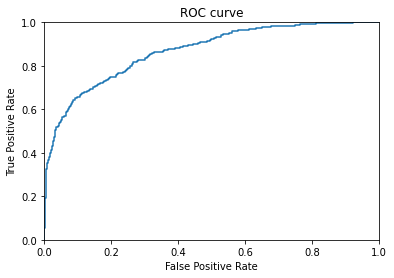

In [120]:
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('ROC curve')

plt.show()

In the final testing our F1 metric increased as did our AUC ROC. We met the minimum requirements for the model. Excellent!

## Research conclusions

<p>In this task, we needed to teach the model to classify clients in order to use our budget more intelligently, and spend it only on those clients who will not leave us in the near future.</p>

<p>To do this, we removed features that we do not need and that do not affect model training (for example, RowNumber is a unique value for each client). Then we replaced the categorical features with numbers using the Ordinal Coding method and checked if there are any duplicates in our data. After that, we filled in the empty values in the tenure field (how many years a person has been a bank client) using an imputer that looks for similar entries and fills in empty values based on this. We also scaled the data so that our model interprets all features as equal in importance.</p>

<p>Then we split our data into 3 samples - training, validation, and test. Based on the first two, we trained and tested our models further.</p>

<p>We used three main learning models - decision tree, random forest, and linear regression. Each time we looked at different combinations of parameters that would give us the best model with the best metrics. We trained these models on the data that we have, and since we had a large imbalance in the data (many customers who remained, but few who left), we also used three ways to deal with the imbalance in the data - upsampling, downsampling, and a classification threshold. As a result, we trained 12 models, and inside each set we looked for the best parameters for each model-imbalance combination.</p>

<p>According to the results of this study, the best model with an F1 metric of 0.62 is a random forest with a modified classification threshold.</p>